In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np

'''
resnet address degradation prob by applying identity maps so that
deep model can not make more error than shallow counterparts
'''

Residual blocks in resnets

In [ ]:
input = Input(shape=(100,100,36), name='input')
layer1 = Conv2D(kernel_size=3, filters=28, padding='same', name='layer1')(input)
layer1_ = BatchNormalization(name='normalize')(layer1)
layer2 = Conv2D(kernel_size=3, filters=36, padding='same', name='layer2')(layer1_)
layer_add = Add(name='add')([layer2, input])
layer_output = ReLU(name='activate')(layer_add)

#first add the two results, then activate, then normalize along batches

residual_block_ = keras.Model(inputs=input, outputs=layer_output)

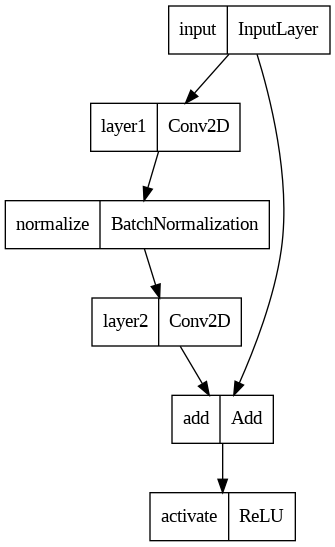

In [ ]:
keras.utils.plot_model(residual_block_)

Left(resnet34) -----------------------------------------------------------------------------------------------
Right(resnet50)


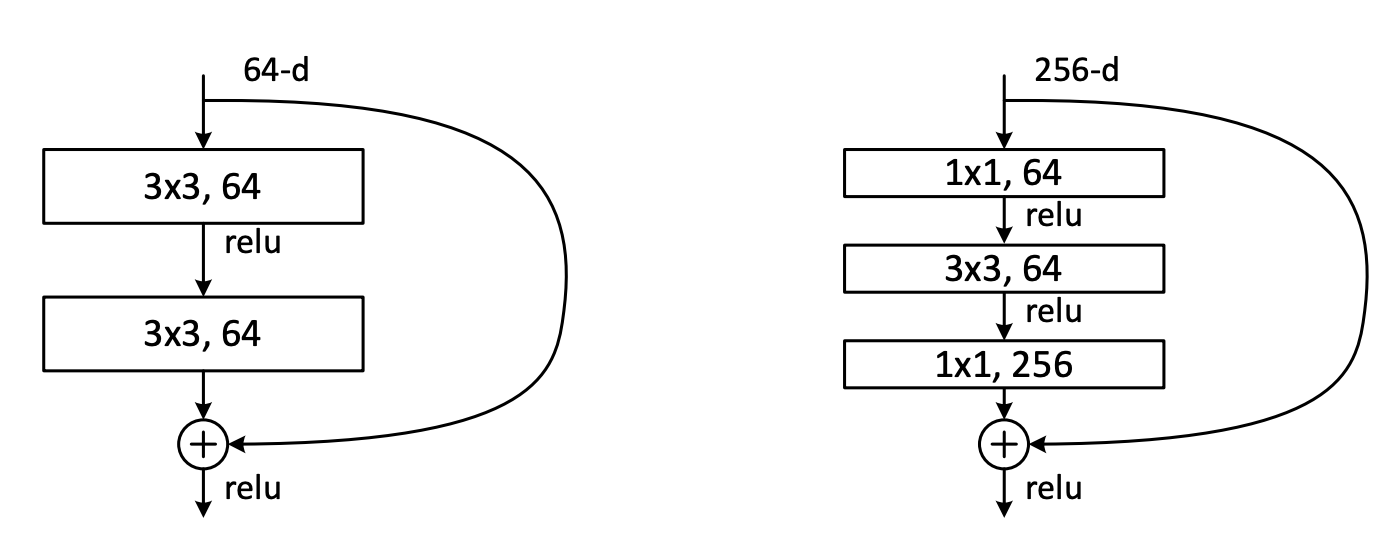

In [ ]:
class residual_block(Layer):

  def __init__(self, number_filters, stride=1):
    super(residual_block, self).__init__()

    self.convolute_1 = Conv2D(kernel_size=(3,3), strides=stride,
                              filters=number_filters, padding='same')
    self.normalize = BatchNormalization()
    self.convolute_2 = Conv2D(kernel_size=(3,3), filters=number_filters,
                              padding='same',
                              strides=1)

    if stride!=1:
      self.downsample = keras.Sequential()
      self.downsample.add(Conv2D(kernel_size=(1,1), filters=number_filters,
                                 strides=stride))
      self.downsample.add(BatchNormalization())
    else:
      self.downsample = lambda x: x

  def call(self, inputs, training=None, **kwargs):

    residual_block_pr = self.downsample(inputs)


    x = self.convolute_1(inputs)
    x = self.normalize(x, training=training)
    x = tf.nn.relu(x)
    x = self.convolute_2(x)
    x = self.normalize(x, training=training)
    return tf.nn.relu(keras.layers.add([residual_block_pr, x]))


In [ ]:
def bring_residual_block(n_blocks, n_filters, stride=1, prefix=None):
    res_block = keras.Sequential(name=prefix)

    res_block.add(residual_block(n_filters, stride=stride))

    for i in range(1, n_blocks):
        res_block.add(residual_block(n_filters, stride=1))

    return res_block


In [ ]:
class ResNet34(keras.Model):

  def __init__(self, repeat_params, name_prefix =''):
    super(ResNet34, self).__init__(name=name_prefix)

    self.entry_conv = Conv2D(kernel_size=(7,7), strides=2,
                             filters=64,
                              padding='same')
    self.normalize = BatchNormalization()
    self.pool = MaxPool2D(pool_size=(3,3), strides=2,
                             padding='same', name='Pool')
    self.l1 = bring_residual_block(n_blocks = repeat_params[0], n_filters=64, prefix='Residual1')
    self.l2 = bring_residual_block(n_blocks = repeat_params[1], n_filters=64*2, stride=2, prefix='Residual2')
    self.l3 = bring_residual_block(n_blocks = repeat_params[2], n_filters=64*3, stride=2, prefix='Residual3')
    self.l4 = bring_residual_block(n_blocks = repeat_params[3], n_filters=64*4, stride=2, prefix='Residual4')

    self.pool_final = GlobalAveragePooling2D(name='avg_pool')
    self.final_l = Dense(1000, activation='softmax', name='fc-1000')


  def call(self, inputs, training=None, **kwargs):
    x = self.entry_conv(inputs)
    x = self.normalize(x, training=training)
    x = tf.nn.relu(x)
    x = self.pool(x)
    x = self.l1(x, training=training)
    x = self.l2(x, training=training)
    x = self.l3(x, training=training)
    x = self.l4(x, training=training)
    x = self.pool_final(x)
    return self.final_l(x)

In [ ]:
model = ResNet34(repeat_params=[3,4,6,3], name_prefix='ResNet34')

In [ ]:
model.build(input_shape=(None, 224,224,3))

In [ ]:
print(model.summary())

Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_60 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 Pool (MaxPooling2D)         multiple                  0         
                                                                 
 Residual1 (Sequential)      (None, 56, 56, 64)        222336    
                                                                 
 Residual2 (Sequential)      (None, 28, 28, 128)       1117824   
                                                                 
 Residual3 (Sequential)      (None, 14, 14, 192)       3903168   
                                                          